In [2]:
import pandas as pd
import numpy as np
#import statsmodels.api as sm
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime, timedelta
import seaborn as sb
import os
os.chdir('/home/saul/python')


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [3]:
bike_rental = pd.read_csv('bike_rental_dataset.csv')

### Data Preprocessing

##### Convert date variable to data format

In [4]:
bike_rental['date'] = bike_rental['datetime'].str.split(" ").str[0]
bike_rental['hour_mins'] = bike_rental['datetime'].str.split(" ").str[1]

bike_rental['date'] = bike_rental['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [5]:
bike_rental['date'].head(-5)

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17345   2012-12-30
17346   2012-12-30
17347   2012-12-30
17348   2012-12-30
17349   2012-12-30
Name: date, Length: 17350, dtype: datetime64[ns]

###### Exclude days from 24/12/2012 onwards

In [6]:
bike_rental = bike_rental[bike_rental['date'] < '2012-12-24']  # remove observation to be predicted

In [7]:
bike_rental['date'].value_counts()

2011-01-01    24
2012-06-26    24
2012-04-23    24
2012-04-24    24
2012-04-25    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 723, dtype: int64

###### Missing values

In [8]:
print(f'Number of rows with missing values: {bike_rental.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.000581767409389726


In [9]:
get_missing_data = bike_rental[bike_rental.isnull().any(axis=1)]

In [10]:
get_missing_data # show missing values in the dataset

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour_mins
14,1/01/2011 14:00,1,0,0,2,0.46,0.4545,NaN,0.2836,106.0,2011-01-01,14:00
56,3/01/2011 11:00,1,0,1,1,0.20,0.1818,NaN,0.3284,51.0,2011-01-03,11:00
93,5/01/2011 1:00,1,0,1,1,0.16,0.1970,NaN,0.0896,6.0,2011-01-05,1:00
166,8/01/2011 5:00,1,0,0,2,0.16,0.1667,NaN,0.1642,5.0,2011-01-08,5:00
762,4/02/2011 5:00,1,0,1,2,0.14,0.1515,NaN,0.1343,7.0,2011-02-04,5:00
3537,1/06/2011 7:00,2,0,1,2,0.70,0.6667,NaN,0.1642,284.0,2011-06-01,7:00
8796,7/01/2012 8:00,1,0,0,1,0.24,0.2576,NaN,0.1045,64.0,2012-01-07,8:00
13102,5/07/2012 3:00,3,0,1,1,0.72,0.6667,NaN,0.1940,7.0,2012-07-05,3:00
15947,2/11/2012 4:00,4,0,1,1,0.30,0.3182,NaN,0.1045,7.0,2012-11-02,4:00
16505,25/11/2012 11:00,4,0,0,2,0.26,0.2576,NaN,0.2239,204.0,2012-11-25,11:00


###### Replace NaN  values with zero in the dataset

In [14]:
bike_rental = bike_rental.replace(np.nan, 0)

In [15]:
get_missing_data = bike_rental[bike_rental.isnull().any(axis=1)]

In [16]:
get_missing_data # show missing values in the dataset

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,hour_mins


###### Convert numerical values to categorical

In [3]:
bike_rental = bike_rental.astype({'season':'string', 'holiday':'category', 'workingday':'category', 
                                  'weather':'category'})

In [7]:
bike_rental['week_number'] = bike_rental['date'].dt.isocalendar().week.astype("string")
type(bike_rental['week_number'])
bike_rental['year'] = bike_rental['date'].dt.isocalendar().year.astype("string")
bike_rental['week_year'] = bike_rental[['week_number', 'year']].agg('_'.join, axis=1) 

In [8]:

bike_rental['season'] = bike_rental['season'].str.replace('1', 'Spring')

bike_rental['season'] = bike_rental['season'].str.replace('2', 'Summer')
bike_rental['season'] = bike_rental['season'].str.replace('3', 'Fall')
bike_rental['season'] = bike_rental['season'].str.replace('4', 'Winter')

In [9]:
bike_rental['season'].value_counts()

Fall      4496
Summer    4409
Winter    4232
Spring    4218
Name: season, dtype: Int64

In [10]:
bike_rental.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,day_of_week,hour,week_number,year,week_year
0,Spring,0,0,1,0.24,0.2879,0.81,0.0,16.0,2011-01-01,5,0,52,2010,52_2010
1,Spring,0,0,1,0.22,0.2727,0.80,0.0,40.0,2011-01-01,5,1,52,2010,52_2010
2,Spring,0,0,1,0.22,0.2727,0.80,0.0,32.0,2011-01-01,5,2,52,2010,52_2010
3,Spring,0,0,1,0.24,0.2879,0.75,0.0,13.0,2011-01-01,5,3,52,2010,52_2010
4,Spring,0,0,1,0.24,0.2879,0.75,0.0,1.0,2011-01-01,5,4,52,2010,52_2010


In [11]:
bike_rental.describe()

,temp,atemp,humidity,windspeed,count,day_of_week,hour
count,17355.000000,17355.000000,17345.000000,17355.000000,17189.000000,17355.000000,17355.000000
mean,0.497376,0.476124,0.627289,0.190146,190.774914,3.015615,11.546816
std,0.192396,0.171704,0.193061,0.122411,181.805639,2.000213,6.914394
min,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.340000,0.333300,0.480000,0.104500,41.000000,1.000000,6.000000
50%,0.500000,0.484800,0.630000,0.194000,144.000000,3.000000,12.000000
75%,0.660000,0.621200,0.780000,0.253700,282.000000,5.000000,18.000000
max,1.000000,1.000000,1.000000,0.850700,977.000000,6.000000,23.000000


In [12]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17355 entries, 0 to 17354
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   season       17355 non-null  string        
 1   holiday      17355 non-null  category      
 2   workingday   17355 non-null  category      
 3   weather      17355 non-null  category      
 4   temp         17355 non-null  float64       
 5   atemp        17355 non-null  float64       
 6   humidity     17345 non-null  float64       
 7   windspeed    17355 non-null  float64       
 8   count        17189 non-null  float64       
 9   date         17355 non-null  datetime64[ns]
 10  day_of_week  17355 non-null  int64         
 11  hour         17355 non-null  int64         
 12  week_number  17355 non-null  string        
 13  year         17355 non-null  string        
 14  week_year    17355 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(5), int64(

In [13]:
bike_rental['date'].value_counts()

2011-01-01    24
2012-04-01    24
2012-04-27    24
2012-04-28    24
2012-04-29    24
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 730, dtype: int64

In [14]:
daily_counts = pd.pivot_table(bike_rental, values = 'count', index=['date']).reset_index()

###### Weekly Bike Counts

In [15]:
bike_rental["first_day_of_the_week"] = bike_rental.date - bike_rental.day_of_week * timedelta(days=1) # Get First day of Week

In [16]:
bike_rental.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,date,day_of_week,hour,week_number,year,week_year,first_day_of_the_week
0,Spring,0,0,1,0.24,0.2879,0.81,0.0,16.0,2011-01-01,5,0,52,2010,52_2010,2010-12-27
1,Spring,0,0,1,0.22,0.2727,0.80,0.0,40.0,2011-01-01,5,1,52,2010,52_2010,2010-12-27
2,Spring,0,0,1,0.22,0.2727,0.80,0.0,32.0,2011-01-01,5,2,52,2010,52_2010,2010-12-27
3,Spring,0,0,1,0.24,0.2879,0.75,0.0,13.0,2011-01-01,5,3,52,2010,52_2010,2010-12-27
4,Spring,0,0,1,0.24,0.2879,0.75,0.0,1.0,2011-01-01,5,4,52,2010,52_2010,2010-12-27


In [17]:
weekly_counts = pd.pivot_table(bike_rental, values = 'count', index=['first_day_of_the_week'], aggfunc= 'sum').reset_index()

In [18]:
weekly_counts.head(-5)

,first_day_of_the_week,count
0,2010-12-27,1786.0
1,2011-01-03,9408.0
2,2011-01-10,9025.0
3,2011-01-17,8770.0
4,2011-01-24,7699.0
...,...,...
95,2012-10-22,49331.0
96,2012-10-29,28762.0
97,2012-11-05,40675.0
98,2012-11-12,37299.0


In [19]:
weekly_counts.to_csv('weekly_bike_counts.csv', index=False)

In [20]:
weekly_counts.describe()

,count
count,105.000000
mean,31230.761905
std,12765.802018
min,0.000000
25%,23132.000000
50%,30779.000000
75%,42323.000000
max,55022.000000


In [21]:
weekly_counts = weekly_counts[weekly_counts['count'] !=0]  # remove zero values (aka 24/12/2012) since this  week
                                                           # is to be predicted and zero value leads incorrect prediction

In [22]:
weekly_counts.describe()

,count
count,104.000000
mean,31531.057692
std,12449.390349
min,1786.000000
25%,23658.500000
50%,30982.000000
75%,42433.250000
max,55022.000000


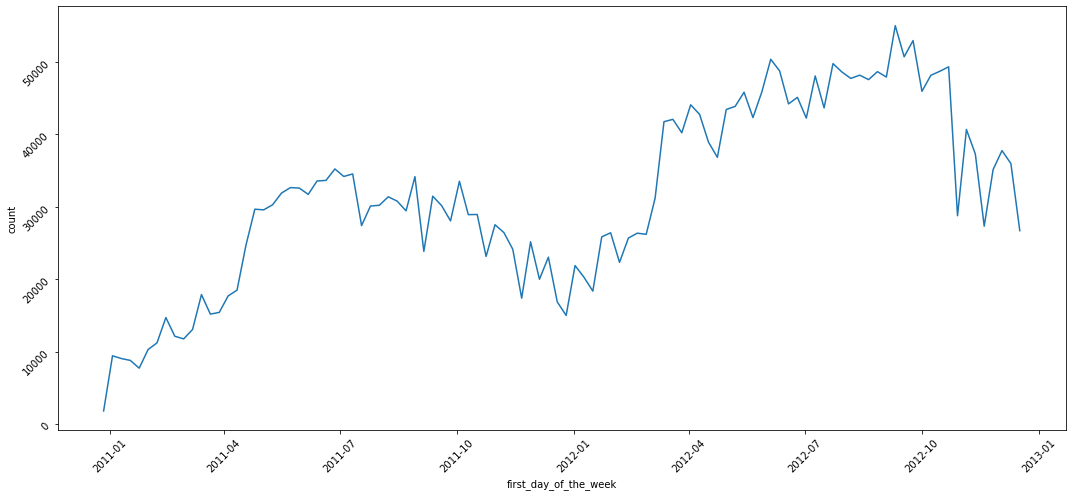

In [23]:
plt.rcParams["figure.figsize"] = [15.00, 7]
plt.rcParams["figure.autolayout"] = True

ax = sb.lineplot(x="first_day_of_the_week", y="count", data=weekly_counts)

ax.tick_params(rotation=45)

plt.show()

###### By looking at the time series graph, there is seasonality during the xmas period (the number of bikes rented during and toward the period is declined) 

###### Trend of bike rentals

<AxesSubplot:ylabel='count'>

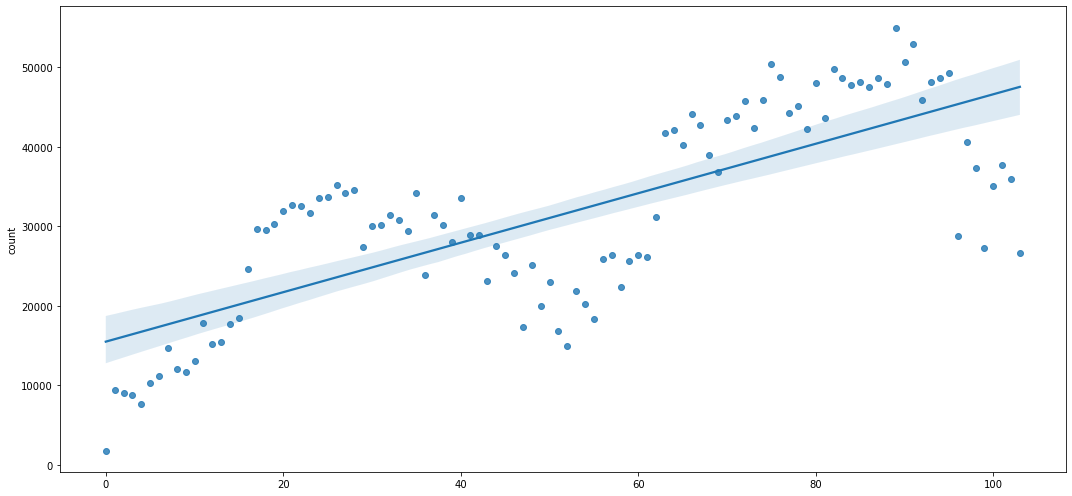

In [24]:
sb.regplot(x=weekly_counts.index, y="count", data=weekly_counts)

#### Predict via Time series auto correlation

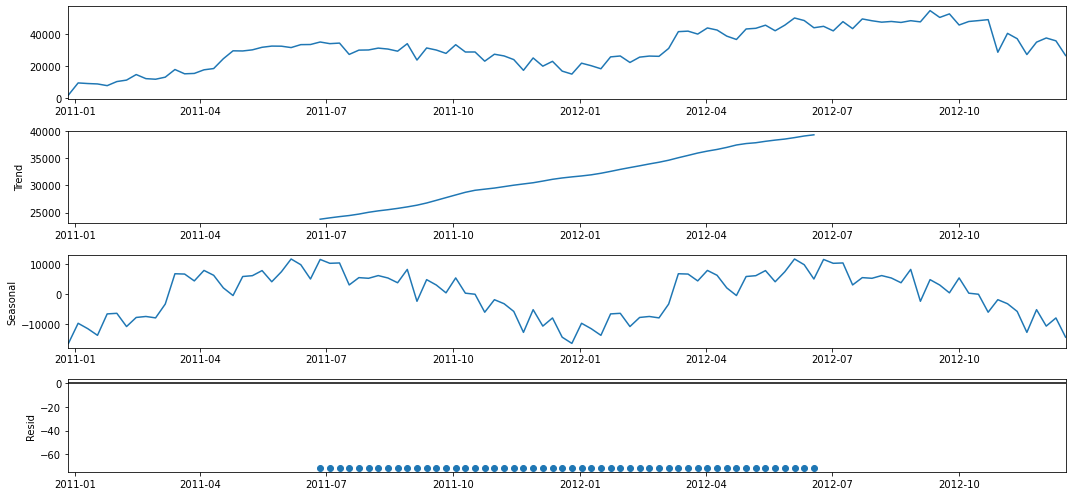

In [25]:
indexed_data_set = weekly_counts.set_index("first_day_of_the_week")

decomp = sm.tsa.seasonal_decompose(indexed_data_set, model='additive') # Additive approach count(t) = Level(t) + Trend(t) + Seasonality(t) + Noise(t)

figure = decomp.plot()

matplotlib.rcParams['figure.figsize'] = [10,5]

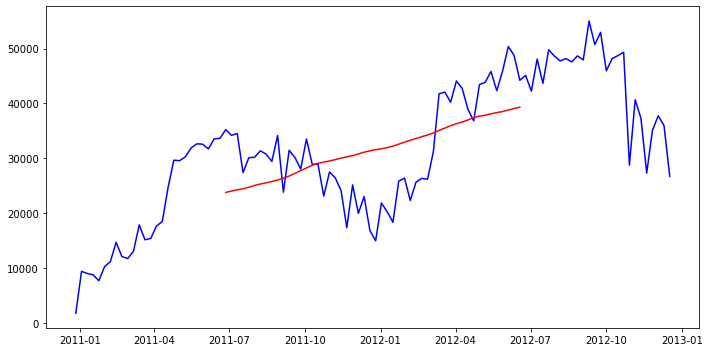

In [26]:
plt.plot(indexed_data_set.index, indexed_data_set['count'], c='blue')
plt.plot(decomp.trend.index, decomp.trend, c='red')

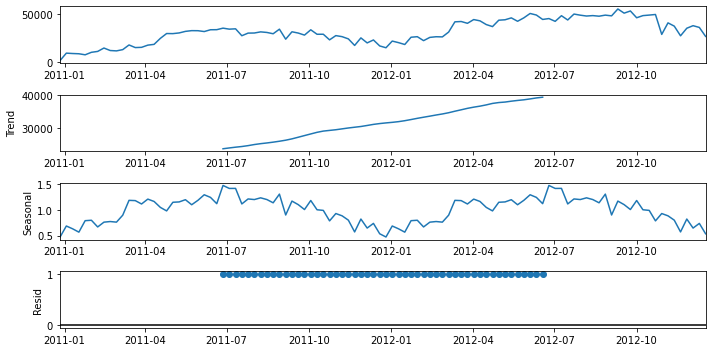

In [27]:
indexed_data_set = weekly_counts.set_index("first_day_of_the_week")

decomp = sm.tsa.seasonal_decompose(indexed_data_set, model='multiplicative') # Multoplicative approach count(t) = Level(t)*Trend(t)*Seasonality(t) + Noise(t)

figure = decomp.plot()

matplotlib.rcParams['figure.figsize'] = [10,5]

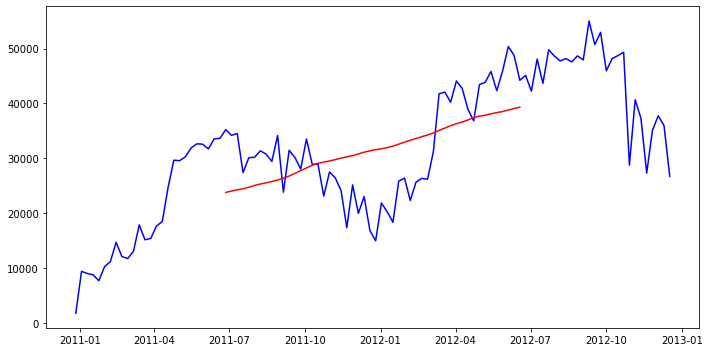

In [28]:
plt.plot(indexed_data_set.index, indexed_data_set['count'], c='blue')
plt.plot(decomp.trend.index, decomp.trend, c='red')

###### Prediction with sklearn RandomForestRegressor

In [29]:
weekly_counts.columns

Index(['first_day_of_the_week', 'count'], dtype='object')

In [30]:
bike_rental.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'date', 'day_of_week', 'hour',
       'week_number', 'year', 'week_year', 'first_day_of_the_week'],
      dtype='object')

In [31]:
weekly_counts = weekly_counts.rename({'count':'weekly_total_rent'})

#add weekly counts to the original dataset
bike_rental_weekly_count = bike_rental.merge(weekly_counts, on = 'first_day_of_the_week', how='left') #add weekly counts

In [32]:
len(bike_rental_weekly_count )

17355

In [33]:
len(bike_rental)

17355

In [34]:
bike_rental_weekly_count.to_excel('bike_rental_weekly_count.xlsx')

###### Based on original dataset

In [37]:
pip install skforecast

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 KB 2.0 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 5.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 4.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  Created wheel for statsmodels: filename=statsmodels-0.13.0-cp310-cp310-linux_x86_64.whl size=19859193 sha256=d459fe2097bd0ca331daa3e29aa181779dcf90e640b0933d8823191005b0e67d
  Stored in directory: /home/saul/.cache/pip/wheels/ad/30/84/c052bf95214a1901b6ea959e60bf33aad07b2ec08f594deff0
Successfully built sta